In [1]:
import numpy as np
from scipy import io as sci
from matplotlib import pyplot as plt
from algorithms.HIO import HIO
from algorithms.ChargeflipHIO_numpy import solver as np_solver
from algorithms.ChargeflipHIO_pytorch import solver as torch_solver
from utils import plot
from skimage.metrics import peak_signal_noise_ratio as PSNR
import torch

## 读取图片

(-0.5, 127.5, 127.5, -0.5)

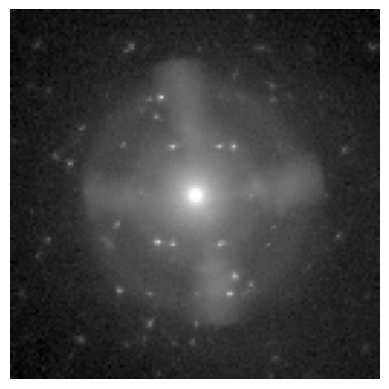

In [2]:
# ima=sci.loadmat('./data/flip_cupcTry.mat')['pict1']
# ima=np.clip(ima*255,0,255).astype(np.uint8)
import cv2

filename = './data/Diff5nmAu.tif'
ima = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
ima = cv2.resize(ima, (128, 128))
plt.imshow(ima, cmap='gray')
plt.axis('off')

## 增加噪音

array([<Axes: title={'center': 'ground truth\n'}>,
       <Axes: title={'center': 'gaussian noise\nalpha=25'}>,
       <Axes: title={'center': 'poisson noise\nalpha=9'}>], dtype=object)

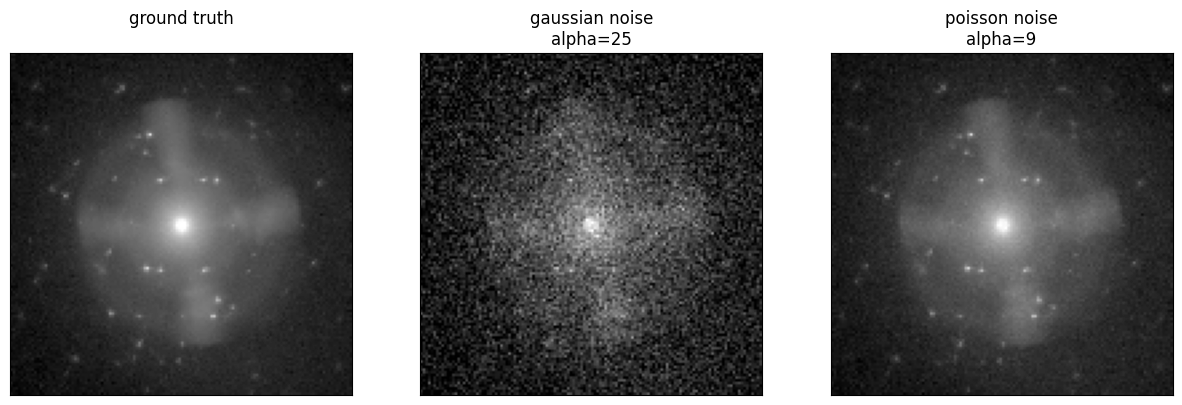

In [3]:
# 高斯噪音
def add_gaussian_noise(ima, sigma):
    noise = np.random.normal(scale=sigma, size=ima.shape)
    noise = noise.round()
    noised_ima = np.clip(ima + noise, 0, 255).astype(np.uint8)
    return noised_ima


# 泊松噪音
def add_poisson_noise(ima, lam):
    noise = np.random.poisson(lam, size=ima.shape).astype(np.uint8)
    noised_ima = np.clip(ima + noise, 0, 255).astype(np.uint8)
    return noised_ima


def normalize(img):
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)


lam = 9  #the amount of poisson noise
sigma = 25  #the amount of gaussian noise 

ima_gaussian = add_gaussian_noise(ima, sigma)
ima_poisson = add_poisson_noise(ima, lam)
ima_gaussian = normalize(ima_gaussian)
ima_poisson = normalize(ima_poisson)
plot.show_images(imgs=[ima, ima_gaussian, ima_poisson], num_cols=3, num_rows=1, scale=5,
                 titles=[f'ground truth\n', f'gaussian noise\nalpha={sigma}',
                         f'poisson noise\nalpha={lam}'], cmap='gray')

## 传统迭代算法
### HIO
(1) 初值敏感：不同的迭代初始值将得到不同的收敛结果，最终恢复的收敛解依赖于迭代算法的初始值；
(2) 局部最优：迭代易陷入停滞而无法达到精确的全局解，最终的收敛解为局部最优值；
(3) 噪声敏感：当所测强度数据有较强的噪声干扰时，相位重建质量显著下降。
当过采样倍数为 2 时，可以从傅里叶测量值中唯一地恢复出原始信号的相位
过采样率$\alpha$定义为实际采样率与待恢复相位采样率的比值，显然过采样率超过 1 时，空域的范围超过真实样品的大小，超出部分可认定为零值，零值
区域即为空域的约束.

array([<Axes: title={'center': 'simulated oversampling\nratio=4'}>,
       <Axes: title={'center': 'prior support'}>,
       <Axes: title={'center': 'poisson noise\nlam=9'}>], dtype=object)

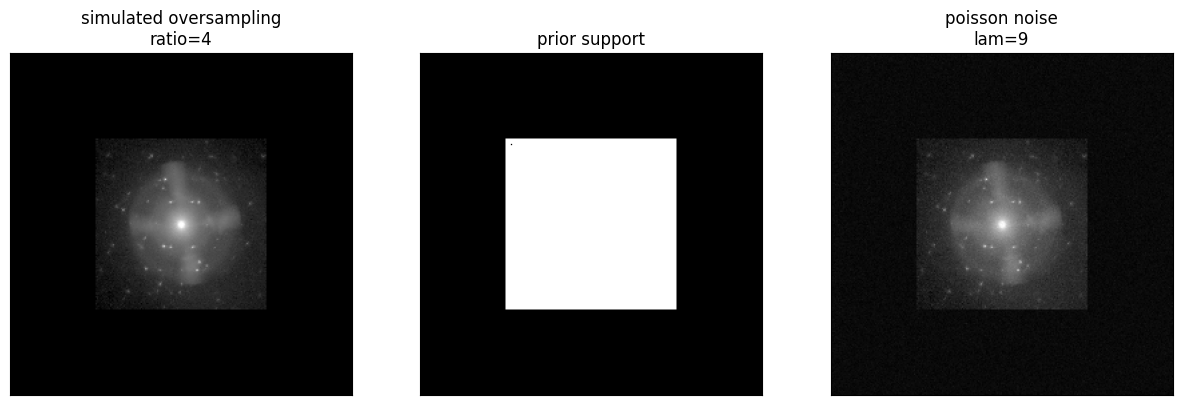

In [4]:
#oversample_ratio=4
# ima.shape
height, width = ima.shape
ima_padded = np.pad(ima, (height // 2, width // 2), 'constant')
ratio = 4
ima_padded_poisson = add_poisson_noise(ima_padded, lam=lam)
ima_padded_poisson = normalize(ima_padded_poisson)
mask = ima_padded > 0
plot.show_images(imgs=[ima_padded, mask, ima_padded_poisson], num_rows=1, num_cols=3, scale=5,
                 titles=[f'simulated oversampling\nratio={ratio}', 'prior support',
                         f'poisson noise\nlam={lam}'], cmap='gray')

C:\Users\Wang Yuze\AppData\Local\Temp\ipykernel_22924\2260448145.py:16: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  f'HIO crop\npsnr={PSNR(ima, denoise_img_hio_crop):.2f}'], cmap='gray')


array([<Axes: title={'center': 'HIO oversampling\n'}>,
       <Axes: title={'center': 'poisson noise crop\n'}>,
       <Axes: title={'center': 'HIO crop\npsnr=17.18'}>], dtype=object)

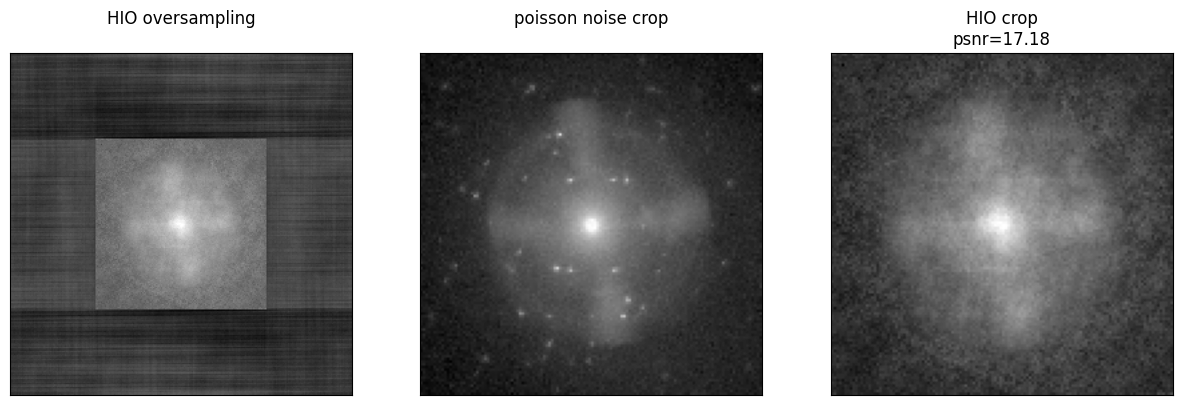

In [5]:
mag = np.abs(np.fft.fft2(ima_padded_poisson))
phase = np.angle(np.fft.fft2(ima_padded_poisson))
beta = 0.9
steps = 200
denoise_img_hio = HIO(mag=mag, mask=mask, x_init=None, beta=beta, steps=steps)
denoise_img_hio_crop = denoise_img_hio[height // 2:height // 2 + height, width // 2:width // 2 + width]
img_padded_poisson_crop = ima_padded_poisson[height // 2:height // 2 + height, width // 2:width // 2 + width]

denoise_img_hio_crop = normalize(denoise_img_hio_crop)
img_padded_poisson_crop = normalize(img_padded_poisson_crop)

plot.show_images(imgs=[denoise_img_hio, img_padded_poisson_crop, denoise_img_hio_crop, ], num_rows=1, num_cols=3,
                 scale=5,
                 titles=[f'HIO oversampling\n',
                         f'poisson noise crop\n',
                         f'HIO crop\npsnr={PSNR(ima, denoise_img_hio_crop):.2f}'], cmap='gray')


### ChargeflipHIO(numpy)
与传统HIO不同，基于原子性约束，不需要已知边界约束

charge flipping step 1 of 200 Rfactor: 0.3004065663223342
charge flipping step 2 of 200 Rfactor: 2.2950183194945275
charge flipping step 3 of 200 Rfactor: 0.6334726618810256
charge flipping step 4 of 200 Rfactor: 1.80980499381609
charge flipping step 5 of 200 Rfactor: 0.7912126855510655
charge flipping step 6 of 200 Rfactor: 1.5262557261330374
charge flipping step 7 of 200 Rfactor: 0.9143219583277876
charge flipping step 8 of 200 Rfactor: 1.8176991486964575
charge flipping step 9 of 200 Rfactor: 1.2603461872280106
charge flipping step 10 of 200 Rfactor: 1.5488814827815485
charge flipping step 11 of 200 Rfactor: 1.2275013690047771
charge flipping step 12 of 200 Rfactor: 1.1851311684814774
charge flipping step 13 of 200 Rfactor: 1.4285449003757287
charge flipping step 14 of 200 Rfactor: 1.617098806359223
charge flipping step 15 of 200 Rfactor: 1.260131051096418
charge flipping step 16 of 200 Rfactor: 1.4904480035636258
charge flipping step 17 of 200 Rfactor: 1.0142637029779131
charge fli

C:\Users\Wang Yuze\AppData\Local\Temp\ipykernel_22924\1425406380.py:7: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  f'chargeflipHIO\npsnr={PSNR(ima, denoise_img_ChargeflipHIO_np):.2f}'], cmap='gray')


array([<Axes: title={'center': 'ground truth\n'}>,
       <Axes: title={'center': 'possion_noise\nlam=9'}>,
       <Axes: title={'center': 'chargeflipHIO\npsnr=10.88'}>],
      dtype=object)

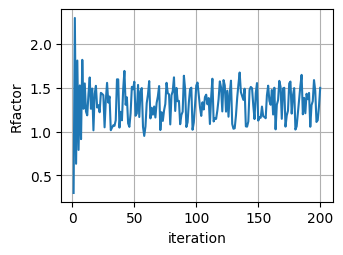

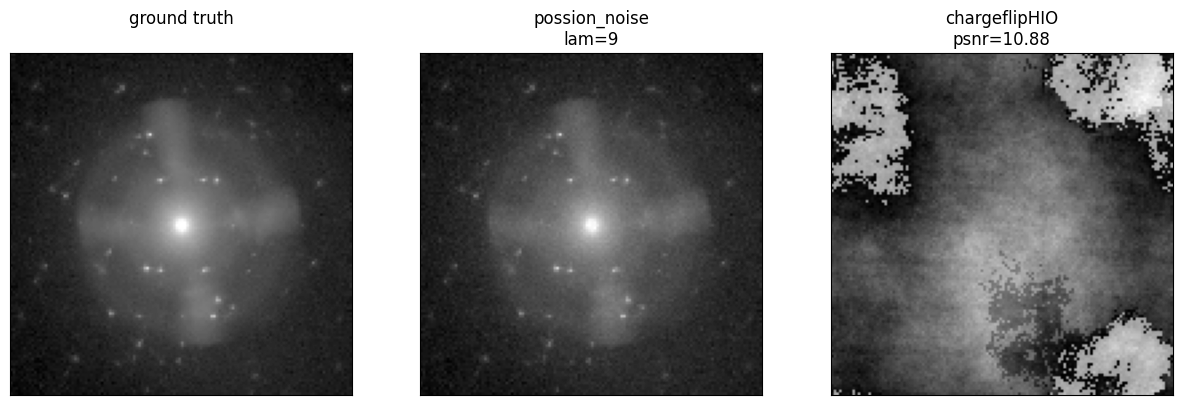

In [6]:
sol = [('CF', 0.17, 200)]
denoise_img_ChargeflipHIO_np, Rhist = np_solver(ima_poisson, sol, True)
denoise_img_ChargeflipHIO_np = normalize(denoise_img_ChargeflipHIO_np)
plot.plot(np.arange(1, len(Rhist) + 1, 1), Rhist, xlabel='iteration', ylabel='Rfactor')
plot.show_images(imgs=[ima, ima_poisson, denoise_img_ChargeflipHIO_np], num_rows=1, num_cols=3, scale=5,
                 titles=['ground truth\n', f'possion_noise\nlam={lam}',
                         f'chargeflipHIO\npsnr={PSNR(ima, denoise_img_ChargeflipHIO_np):.2f}'], cmap='gray')

### ChargeflipHIO(pytorch)

charge flipping step 1 of 200 Rfactor: 0.3235044493470797
charge flipping step 2 of 200 Rfactor: 0.676090401972246
charge flipping step 3 of 200 Rfactor: 2.2249423675125803
charge flipping step 4 of 200 Rfactor: 0.6425253600534411
charge flipping step 5 of 200 Rfactor: 2.1030277994223914
charge flipping step 6 of 200 Rfactor: 0.8490602123082058
charge flipping step 7 of 200 Rfactor: 1.8790987459478805
charge flipping step 8 of 200 Rfactor: 1.156581635187689
charge flipping step 9 of 200 Rfactor: 1.2294469980178893
charge flipping step 10 of 200 Rfactor: 1.347324477176852
charge flipping step 11 of 200 Rfactor: 1.6566393779744775
charge flipping step 12 of 200 Rfactor: 1.1543941652520533
charge flipping step 13 of 200 Rfactor: 1.328853181985389
charge flipping step 14 of 200 Rfactor: 1.2220785759970194
charge flipping step 15 of 200 Rfactor: 1.550784212863866
charge flipping step 16 of 200 Rfactor: 1.550057079293775
charge flipping step 17 of 200 Rfactor: 1.1080921379145983
charge flipp

C:\Users\Wang Yuze\AppData\Local\Temp\ipykernel_22924\2757167590.py:8: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  f'chargeflipHIO\npsnr={PSNR(ima, denoise_img_ChargeflipHIO_np):.2f}'], cmap='gray')


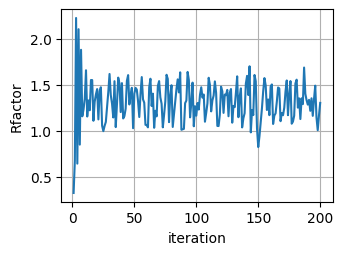

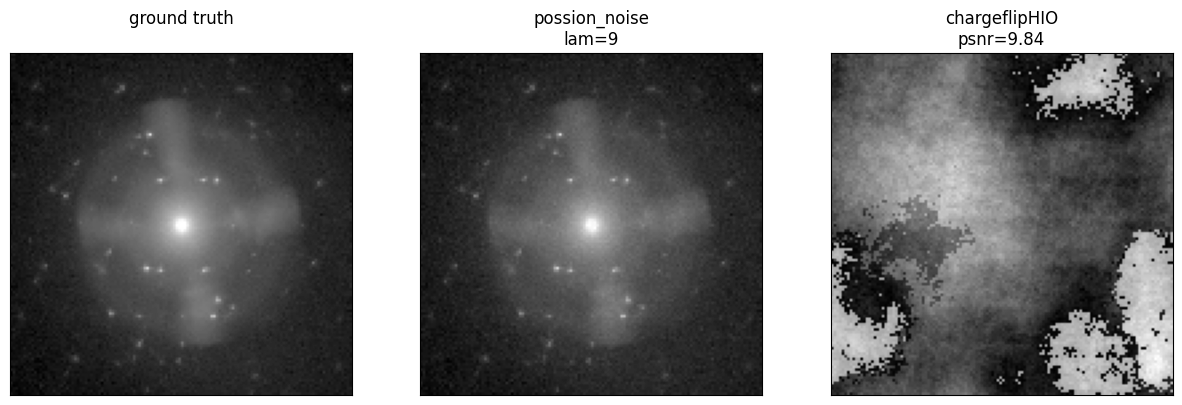

In [7]:
device="cuda" if torch.cuda.is_available() else "cpu"
sol = [('CF', 0.17, 200)]
denoise_img_ChargeflipHIO_np, Rhist = torch_solver(ima_poisson, sol,device=device,verbose=True)
denoise_img_ChargeflipHIO_np = normalize(denoise_img_ChargeflipHIO_np)
plot.plot(np.arange(1, len(Rhist) + 1, 1), Rhist, xlabel='iteration', ylabel='Rfactor')
plot.show_images(imgs=[ima, ima_poisson, denoise_img_ChargeflipHIO_np], num_rows=1, num_cols=3, scale=5,
                 titles=['ground truth\n', f'possion_noise\nlam={lam}',
                         f'chargeflipHIO\npsnr={PSNR(ima, denoise_img_ChargeflipHIO_np):.2f}'], cmap='gray')
torch.cuda.empty_cache()

## 基于深度学习的方法
### Prdeep(RIDNet)
基于HIO方法，利用深度神经网络强大的去噪能力，提升其在真实噪音下的恢复效果

In [8]:
from models.RIDNet.model import RIDNet
from torchsummary import summary
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
ridnet = RIDNet(in_channels=1, out_channels=1)
ridnet.load_state_dict(torch.load('models/RIDNet/ridnet.pth'))
ridnet = ridnet.to(device=device)
summary(ridnet, (1, 256, 256), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
            Conv2d-2         [-1, 64, 256, 256]          36,928
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
              ReLU-5         [-1, 64, 256, 256]               0
            Conv2d-6         [-1, 64, 256, 256]          36,928
              ReLU-7         [-1, 64, 256, 256]               0
            Conv2d-8         [-1, 64, 256, 256]          36,928
              ReLU-9         [-1, 64, 256, 256]               0
           Conv2d-10         [-1, 64, 256, 256]          73,792
             ReLU-11         [-1, 64, 256, 256]               0
Merge_And_Run_Unit-12         [-1, 64, 256, 256]               0
           Conv2d-13         [-1, 64, 256, 256]          36,928
             ReLU-14         [-1, 64, 

C:\Users\Wang Yuze\AppData\Local\Temp\ipykernel_22924\966916610.py:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  f'RIDNet\npsnr={PSNR(ima, denoise_img_ridnet):.2f}'], scale=5, cmap='gray')


array([<Axes: title={'center': 'ground truth\n'}>,
       <Axes: title={'center': 'poisson noise\nlam=9'}>,
       <Axes: title={'center': 'RIDNet\npsnr=25.78'}>], dtype=object)

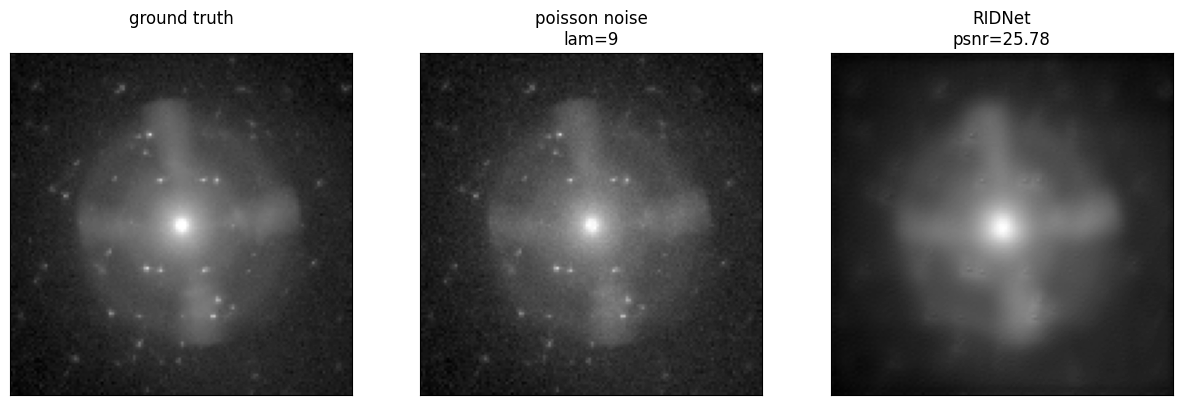

In [10]:
n = ima.size
height, width = ima.shape

ridnet.eval()
with torch.no_grad():
    ima_poisson_torch = torch.from_numpy(ima_poisson).reshape(1, 1, height, width).float().to(device=device)
    denoise_img_ridnet = ridnet(ima_poisson_torch).cpu()
    del ima_poisson_torch
denoise_img_ridnet = torch.squeeze(torch.squeeze(denoise_img_ridnet, dim=0), dim=0).detach().numpy()
denoise_img_ridnet = normalize(denoise_img_ridnet)

plot.show_images(imgs=[ima, ima_poisson, denoise_img_ridnet], num_cols=3, num_rows=1,
                 titles=['ground truth\n', f'poisson noise\nlam={lam}',
                         f'RIDNet\npsnr={PSNR(ima, denoise_img_ridnet):.2f}'], scale=5, cmap='gray')

C:\Users\Wang Yuze\AppData\Local\Temp\ipykernel_22924\4038342948.py:27: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  f'HIO\npsnr={PSNR(ima, denoise_img_hio_crop):.2f}',
C:\Users\Wang Yuze\AppData\Local\Temp\ipykernel_22924\4038342948.py:28: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  f'PrDeep\npsnr={PSNR(ima,denoise_img_prdeep):.2f}']


array([<Axes: title={'center': 'poisson noise\nlam=9'}>,
       <Axes: title={'center': 'HIO\npsnr=17.18'}>,
       <Axes: title={'center': 'PrDeep\npsnr=18.90'}>], dtype=object)

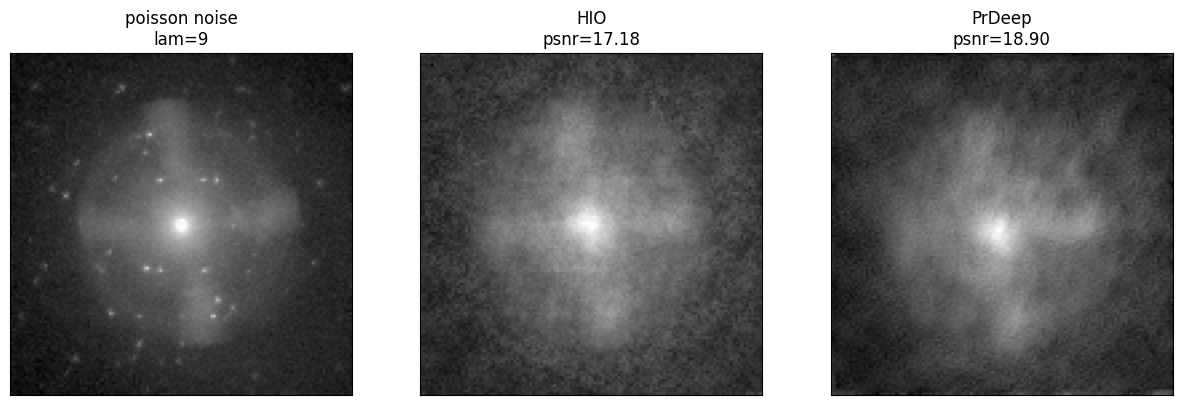

In [11]:
from algorithms.fasta import fastaOpts
from algorithms.prdeep import ProxOpts, prdeep

m = ima_padded.size
p_height, p_width = ima_padded.shape

fasta_opts = fastaOpts()
fasta_opts.max_iters = 200
fasta_opts.tol = 1e-7
fasta_opts.recordObjective = False
prox_opts = ProxOpts(height=height, width=width, denoiser=ridnet, prox_iters=1, sigma_w=1, lb=1,
                     device=device)

HIO_init = torch.from_numpy(denoise_img_hio_crop).float()
y = torch.from_numpy(np.abs(np.fft.fftn(ima_padded_poisson))).float()
Oversample = torch.eye(m)
mask = torch.nn.functional.pad(torch.ones(height, width), (
    (p_height - height) // 2, (p_height - height) // 2, (p_width - width) // 2, (p_width - width) // 2)) > 0
Oversample = Oversample[:, mask.view(-1)]
A = lambda x: torch.fft.fftn((Oversample @ x.reshape(-1, 1)).reshape(p_height, p_width))
At = lambda x: (Oversample.T @ (torch.real(torch.fft.ifftn(x.reshape(p_height, p_width)))).reshape(-1, 1))
denoise_img_prdeep = prdeep(A, At, y, HIO_init.reshape(-1, 1), fasta_opts, prox_opts).solution
denoise_img_prdeep = denoise_img_prdeep.reshape(height, width).numpy()
denoise_img_prdeep = normalize(denoise_img_prdeep)
plot.show_images(imgs=[img_padded_poisson_crop, denoise_img_hio_crop, denoise_img_prdeep], num_rows=1, num_cols=3,scale=5,cmap='gray',
                 titles=[f'poisson noise\nlam={lam}',
                         f'HIO\npsnr={PSNR(ima, denoise_img_hio_crop):.2f}',
                         f'PrDeep\npsnr={PSNR(ima,denoise_img_prdeep):.2f}']
                 )
